In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
import pandas as pd
import ast
import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader, Subset
from transformers import BertTokenizer, BertModel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from transformers import BertForTokenClassification
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

In [56]:
df_all = pd.read_csv('/content/drive/MyDrive/MSC - research/20240720/df_regression_539980_20240720.csv');

df = pd.DataFrame(columns=['tokens', 'aspects', 'sentiments'])

df['tokens'] = df_all['tokens'].apply(ast.literal_eval)
df['aspects'] = df_all['bio_tags'].apply(ast.literal_eval)
df['sentiments'] = df_all['sentiment_tags'].apply(ast.literal_eval)

In [57]:
# Define the mapping for aspects
aspect_mapping = {
    'O': 'O',
    'B-overall': 'overall',
    'B-length': 'length',
    'B-hip': 'hip',
    'B-buttoned': 'buttoned',
    'B-neck': 'neck',
    'B-sleeve': 'sleeve',
    'B-chest': 'chest',
    'B-waist': 'waist',
    'B-shoulder': 'shoulder',
    'B-length_indirect': 'length',
    'B-buttoned_indirect': 'buttoned',
    'B-sleeve_indirect': 'sleeve',
    'B-overall_indirect': 'overall',
    'I-overall': 'overall',
    'I-length': 'length',
    'I-hip': 'hip',
    'I-buttoned': 'buttoned',
    'I-neck': 'neck',
    'I-sleeve': 'sleeve',
    'I-chest': 'chest',
    'I-waist': 'waist',
    'I-shoulder': 'shoulder',
    'I-length_indirect': 'length',
    'I-buttoned_indirect': 'buttoned',
    'I-sleeve_indirect': 'sleeve',
    'I-overall_indirect': 'overall',
}

# Define the mapping for sentiments
sentiment_mapping = {
    'O': 'O',
    'B-negative': 'negative',
    'I-negative': 'negative',
    'B-neutral': 'neutral',
    'I-neutral': 'neutral',
    'B-positive': 'positive',
    'I-positive': 'positive',
}

# Function to apply mappings
def apply_mapping(value, mapping):
    return [mapping.get(item, 'out') for item in value]

# Update the DataFrame
df['aspects'] = df['aspects'].apply(apply_mapping, args=(aspect_mapping,))
df['sentiments'] = df['sentiments'].apply(apply_mapping, args=(sentiment_mapping,))


In [58]:
def get_labels(column):
  # Extract distinct values from the lists
  distinct_values = set()
  df[column].apply(lambda x: distinct_values.update(x))

  # Convert the set to a list if you need a list format
  distinct_values_list = list(distinct_values)
  return distinct_values_list

aspect_count = len(get_labels('aspects'))
sentiment_count = len(get_labels('sentiments'))
max_length = df['tokens'].apply(len).max()
out_of_aspect_id = -100

In [59]:
def label_to_id(label):
    # label_dict = {'O': -100, 'B-overall': 0, 'B-length_indirect': 1, 'B-hip': 2, 'B-buttoned_indirect': 3, 'B-neck': 4,
    #               'B-sleeve': 5, 'B-sleeve_indirect': 6, 'B-buttoned': 7, 'B-shoulder': 8, 'B-overall_indirect': 9,
    #               'B-length': 10, 'B-chest': 11, 'B-waist': 12}
    label_dict = {'O': out_of_aspect_id, 'overall': 0, 'length': 1, 'hip': 2, 'buttoned': 3, 'neck': 4,
                  'sleeve': 5, 'shoulder': 6,'chest': 6, 'waist': 8}
    return label_dict.get(label, out_of_aspect_id)

def sentiment_to_id(sentiment):
    # sentiment_dict = {'O': -100, 'B-negative': 0, 'B-neutral': 1, 'I-negative': 2, 'B-positive': 3, 'I-positive': 4}
    sentiment_dict = {'O': out_of_aspect_id, 'negative': 0, 'neutral': 1, 'positive': 2}
    return sentiment_dict.get(sentiment, out_of_aspect_id)


In [60]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        record = self.df.iloc[idx]
        tokens = record['tokens']
        aspects = record['aspects']
        sentiments = record['sentiments']

        bert_tokens = []
        bert_aspects = []
        bert_sentiments = []

        # Tokenize each token and extend the corresponding lists
        for token, aspect, sentiment in zip(tokens, aspects, sentiments):
            tokenized = self.tokenizer.tokenize(token)
            bert_tokens.extend(tokenized)
            bert_aspects.extend([aspect] * len(tokenized))
            bert_sentiments.extend([sentiment] * len(tokenized))

        # Convert tokens to IDs and create tensors
        bert_ids = self.tokenizer.convert_tokens_to_ids(bert_tokens)
        ids_tensor = torch.tensor(bert_ids)

        aspect_tensor = torch.tensor([label_to_id(aspect) for aspect in bert_aspects], dtype=torch.long)
        sentiment_tensor = torch.tensor([sentiment_to_id(sentiment) for sentiment in bert_sentiments], dtype=torch.long)
        attention_mask = [1] * len(bert_ids)
        attention_tensor = torch.tensor(attention_mask)

        return {
          'bert_tokens': bert_tokens,
          'ids_tensor': ids_tensor,
          'aspect_tensor': aspect_tensor,
          'sentiment_tensor': sentiment_tensor,
          'attention_tensor': attention_tensor
        }

        # return bert_tokens, ids_tensor, aspect_tensor, sentiment_tensor

    def __len__(self):
        return len(self.df)


In [61]:
class BERTModel(torch.nn.Module):
    def __init__(self, tokenizer, model, optimizer):
        super().__init__()
        # super(BERTModel, self).__init__()
        self.tokenizer = tokenizer
        self.model = model
        # self.optimizer = optimizer
        # self.loss_fn = loss_fn # BERTOKENCLASSIFIER USES CROSS ENTROPY LOSS BY DEFAULT

    def evaluate(self, val_loader):
      return 1,1

    # def forward(self, ids_tensor, label_tensors, masks_tensors):
    #     outputs = self.model(input_ids=ids_tensor, labels=label_tensors, attention_mask=masks_tensors)
    #     loss = outputs.loss
    #     logits = outputs.logits
    #     preds = torch.argmax(logits, dim=-1)
    #     return loss, preds

    def test(self, test_loader):
        _, accuracy = self.evaluate(test_loader)
        print(f"Test Accuracy: {accuracy:.4f}")

    def compute_accuracy(self, preds, labels):
        return (preds == labels).float().mean().item()
        # correct = (preds == labels).sum().item()
        # total = labels.numel()
        # accuracy = correct / total
        # return accuracy

    def plot_training_and_validation(self, train_losses, train_accuracies, val_losses, val_accuracies):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training & Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Training Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title('Training & Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

In [77]:
class AspectModel(BERTModel):
    def __init__(self, tokenizer, model, optimizer, num_labels):
        super().__init__(tokenizer, model, optimizer)
        self.num_labels = num_labels

    def train(self, train_loader, val_loader, epochs=3, lr=1e-5):
        self.model.train()
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)
        # optimizer = self.optimizer(self.model.parameters(), lr=lr)
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []

        for epoch in range(epochs):
            for data in tqdm(train_loader):
                tokens = data['bert_tokens']
                ids_tensor = data['ids_tensor']
                aspect_labels = data['aspect_tensor']
                attention_tensor = data['attention_tensor']

                outputs = self.model(input_ids=ids_tensor, attention_mask=attention_tensor, labels=aspect_labels)
                loss = outputs.loss
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1)
    #     outputs = self.model(input_ids=ids_tensor, labels=label_tensors, attention_mask=masks_tensors)
    #     loss = outputs.loss
    #     logits = outputs.logits
    #     preds = torch.argmax(logits, dim=-1)
    #     return loss, preds
                # loss, preds = self.model(ids_tensor=ids_tensor, label_tensors=aspect_labels, masks_tensors=attention_tensor)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                accuracy = self.compute_accuracy(preds, aspect_labels)
                train_losses.append(loss.item())
                train_accuracies.append(accuracy)

            print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Train Accuracy = {train_accuracies[-1]:.4f}")
            val_loss, val_accuracy = self.test(val_loader)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

        self.plot_training_and_validation(train_losses, train_accuracies, val_losses, val_accuracies)

    def test(self, test_loader):
        self.model.eval()
        test_loss, test_correct, test_total = 0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for data in tqdm(test_loader):
                tokens = data['bert_tokens']
                ids_tensor = data['ids_tensor']
                aspect_labels = data['aspect_tensor']
                attention_tensor = data['attention_tensor']

                outputs = self.model(input_ids=ids_tensor, attention_mask=attention_tensor, labels=aspect_labels)
                loss = outputs.loss
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1)

                test_loss += loss.item()
                accuracy = self.compute_accuracy(preds, aspect_labels)
                test_total += aspect_labels.numel()
                all_preds.extend(preds.view(-1).tolist())
                all_labels.extend(aspect_labels.view(-1).tolist())

        test_avg_loss = test_loss / len(test_loader)
        # print("Test Classification Report:")
        # print(classification_report(all_labels, all_preds, labels=list(range(self.num_labels)), zero_division=0))
        return test_avg_loss, accuracy

    def predict(self, sentence):
        self.model.eval()
        with torch.no_grad():
            # Encode the sentence using the tokenizer
            encoding = self.tokenizer.encode_plus(
                sentence,
                add_special_tokens=True,
                return_tensors='pt',
                padding=True,
                truncation=True
            )
            input_tensor = encoding['input_ids']
            attention_tensor = encoding['attention_mask']

            outputs = self.model(input_ids=input_tensor, attention_mask=attention_tensor)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

        predictions = preds.view(-1).tolist()
        tokenized_words = self.tokenizer.convert_ids_to_tokens(input_tensor[0])
        return tokenized_words, predictions, outputs

In [78]:
def collate_fn(batch):
  # Extracting all elements from each data point in the batch
  bert_tokens = [item['bert_tokens'] for item in batch]
  ids_tensors = [item['ids_tensor'] for item in batch]
  aspect_tensors = [item['aspect_tensor'] for item in batch]
  sentiment_tensors = [item['sentiment_tensor'] for item in batch]
  attention_tensors = [item['attention_tensor'] for item in batch]

  # bert_tokens = pad_sequence(bert_tokens, batch_first=True)
  ids_tensor = pad_sequence(ids_tensors, batch_first=True)
  aspect_tensor = pad_sequence(aspect_tensors, batch_first=True, padding_value=out_of_aspect_id)
  sentiment_tensor = pad_sequence(sentiment_tensors, batch_first=True, padding_value=out_of_aspect_id)
  attention_tensor = pad_sequence(attention_tensors, batch_first=True, padding_value=0)

  return {
      'bert_tokens': bert_tokens,
      'ids_tensor': ids_tensor,
      'aspect_tensor': aspect_tensor,
      'sentiment_tensor': sentiment_tensor,
      'attention_tensor': attention_tensor
}

In [79]:
def split_dataset(dataset, val_split=0.3, test_split=0.3):
    indices = list(range(len(dataset)))

    # Split into train+validation and test sets
    train_val_indices, test_indices = train_test_split(indices, test_size=test_split, random_state=42)

    # Split train+validation set into train and validation sets
    train_indices, val_indices = train_test_split(train_val_indices, test_size=val_split, random_state=42)

    train_set = Subset(dataset, train_indices)
    val_set = Subset(dataset, val_indices)
    test_set = Subset(dataset, test_indices)

    return train_set, val_set, test_set


In [80]:
dataset = BERTDataset(df, BertTokenizer.from_pretrained('bert-base-uncased'))
train_set, val_set, test_set = split_dataset(dataset)


In [81]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [82]:
aspect_model = AspectModel(
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased'),
    model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=aspect_count),
    optimizer = torch.optim.AdamW,
    num_labels=aspect_count
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


100%|██████████| 6/6 [00:54<00:00,  9.04s/it]


Epoch 1: Train Loss = 1.7874, Train Accuracy = 0.0156


100%|██████████| 6/6 [00:52<00:00,  8.69s/it]


Epoch 2: Train Loss = 1.4816, Train Accuracy = 0.0926


100%|██████████| 6/6 [00:49<00:00,  8.28s/it]


Epoch 3: Train Loss = 1.7597, Train Accuracy = 0.0476


100%|██████████| 6/6 [00:49<00:00,  8.33s/it]


Epoch 4: Train Loss = 1.5416, Train Accuracy = 0.0208


100%|██████████| 6/6 [00:50<00:00,  8.36s/it]


Epoch 5: Train Loss = 0.8403, Train Accuracy = 0.0556


100%|██████████| 6/6 [00:53<00:00,  8.85s/it]


Epoch 6: Train Loss = 0.9306, Train Accuracy = 0.0364


100%|██████████| 6/6 [00:45<00:00,  7.59s/it]


Epoch 7: Train Loss = 0.1973, Train Accuracy = 0.1364


100%|██████████| 6/6 [00:49<00:00,  8.24s/it]


Epoch 8: Train Loss = 0.7864, Train Accuracy = 0.0508


100%|██████████| 6/6 [00:50<00:00,  8.48s/it]


Epoch 9: Train Loss = 0.2997, Train Accuracy = 0.0638


100%|██████████| 6/6 [00:46<00:00,  7.83s/it]


Epoch 10: Train Loss = 0.1206, Train Accuracy = 0.0600


100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


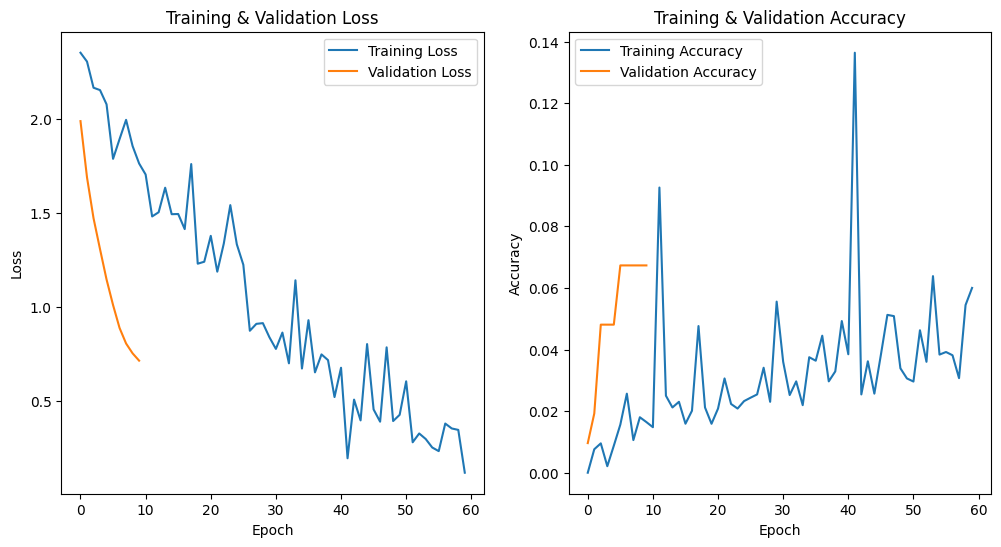

In [83]:
aspect_model.train(train_loader, val_loader, epochs=10, lr=1e-5)